In [3]:
import numpy as np
import pandas as pd

In [4]:
df=pd.read_csv('diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
#checking how much the correlation is
df.corr()['Outcome']

,Outcome
Pregnancies,0.221898
Glucose,0.466581
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
BMI,0.292695
DiabetesPedigreeFunction,0.173844
Age,0.238356
Outcome,1.000000


In [12]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [13]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [17]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [18]:
x=sc.fit_transform(x)

In [20]:
x

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [21]:
x.shape

(768, 8)

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [33]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [23]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout

In [29]:
#pip install keras-tuner

In [30]:
#using keras tuner to know the best of our model and then would extract that and fit the model
import keras_tuner as kt

In [48]:
def build_model(hp):
  model=Sequential()

  counter=0;
  for i in range (hp.Int('layers',min_value=1,max_value=20)):
    if counter==0:

      model.add(Dense(hp.Int('units'+str(i),min_value=8,max_value=128,step=4),activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid','elu']),input_dim=8))
      model.add(Dropout(hp.Choice('dropout '+ str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))

    else:
      model.add(Dense(hp.Int('units'+str(i),min_value=8,max_value=128,step=4),activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid','elu'])))
      model.add(Dropout(hp.Choice('dropout '+ str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))

    counter+=1

  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer=hp.Choice('optimizer ',values=['rmsprop','adam','sgd','nesterov','adagrad']),loss='binary_crossentropy',metrics=['accuracy'])
  return model



In [49]:
tuner=kt.RandomSearch(build_model,objective='val_accuracy',max_trials=4,directory='thisdir',project_name="trying_again")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_val,y_val))

Trial 4 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.6829268336296082
Total elapsed time: 00h 00m 11s


In [51]:
tuner.get_best_hyperparameters()[0].values

{'layers': 1,
 'units0': 60,
 'activation0': 'elu',
 'dropout 0': 0.3,
 'optimizer ': 'sgd'}

In [52]:
model=tuner.get_best_models(num_models=1)[0]

In [53]:
model.fit(x_train,y_train,batch_size=32,epochs=100,initial_epoch=5,validation_data=(x_val,y_val))

Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6956 - loss: 0.5728 - val_accuracy: 0.6829 - val_loss: 0.5776
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7350 - loss: 0.5599 - val_accuracy: 0.6911 - val_loss: 0.5635
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7079 - loss: 0.5633 - val_accuracy: 0.7073 - val_loss: 0.5517
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6897 - loss: 0.5778 - val_accuracy: 0.7398 - val_loss: 0.5412
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7254 - loss: 0.5511 - val_accuracy: 0.7561 - val_loss: 0.5322
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7901 - loss: 0.4951 - val_accuracy: 0.7561 - val_loss: 0.5240
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7513 - loss: 0.5105 - val_accuracy: 0.7561 - val_loss: 0.5171
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7793 - loss: 0.5022 - val_accuracy: 0.756

In [59]:
train_accuracy=model.history.history['accuracy']
val_accuracy=model.history.history['val_accuracy']
len(train_accuracy)

95

In [60]:
import matplotlib.pyplot as plt


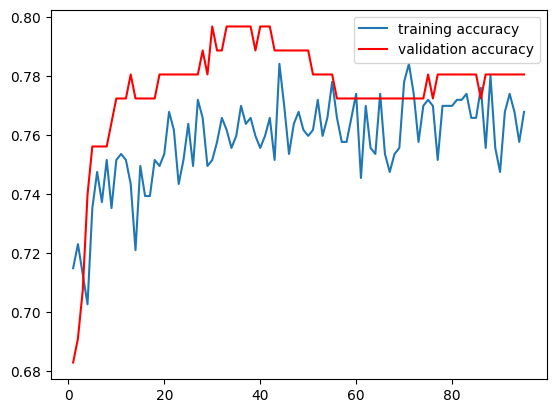

In [70]:
plt.plot([i for i in range(1,96)],train_accuracy)
plt.plot([i for i in range(1,96)],val_accuracy,c="red")
plt.legend(["training accuracy","validation accuracy"])
plt.show()


In [66]:
from sklearn.metrics import accuracy_score

In [63]:
y_output=model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [65]:
out=[]
for i in y_output:
  if i[0]>0.5:
    out.append(1)
  else:
    out.append(0)


In [69]:
accuracy_score(y_test,out)

0.7337662337662337